In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from icecream import ic

import emcee
import time
import corner

plt.rc('text', usetex=True)
plt.rc('font', family='STIXGeneral')

# Parameter fit: Bayesian inference with MCMC

In [8]:
# walkers and chains for all fits
nwalkers = 128
niter = 500

## Sodium at detector 1
As our model, we choose a sum of a lognormal distribution(Compton scattering) and two gaussian distributions (511keV and 1275keV)

\begin{align}
    M(\vec{\theta}, x) &= a_1 \cdot P_{logn}((\mu_1,\sigma_1),x) + a_2 \cdot P_{gauss}((\mu_2,\sigma_2), x) + a_3 \cdot P_{gauss}((\mu_3,\sigma_3), x) \\
    P_{logn}((\mu,\sigma), x) &= \cdot \frac{1}{x \cdot \sigma \sqrt{2\pi}} \exp \left[ -\frac{1}{2} \left ( \frac{\ln x - \mu}{\sigma} \right )^2  \right] \\
    P_{gauss}((\mu,sigma), x) &= \cdot \frac{1}{\sigma \sqrt{2\pi}} \exp \left[ -\frac{1}{2} \left( \frac{x-\mu}{\sigma} \right)^2 \right ] \\
    \vec{\theta} &= (\mu_1, \mu_2, \mu_3, \sigma_1, \sigma_2, \sigma_3, a_1, a_2, a_3)^T
\end{align}

Starting burn-in period


/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


Burn-in period complete
Starting chains
...Complete!
Time required:   180.26734113693237


/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


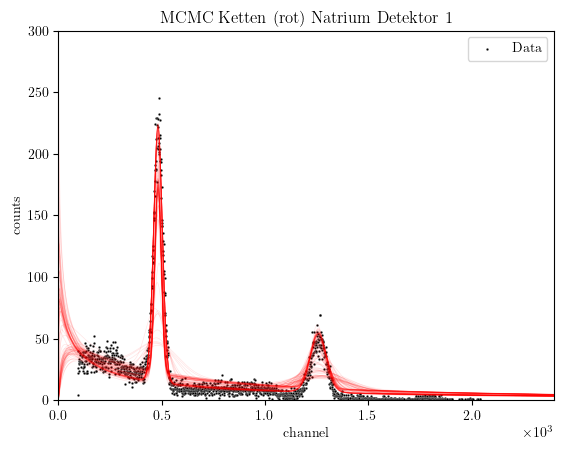

/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


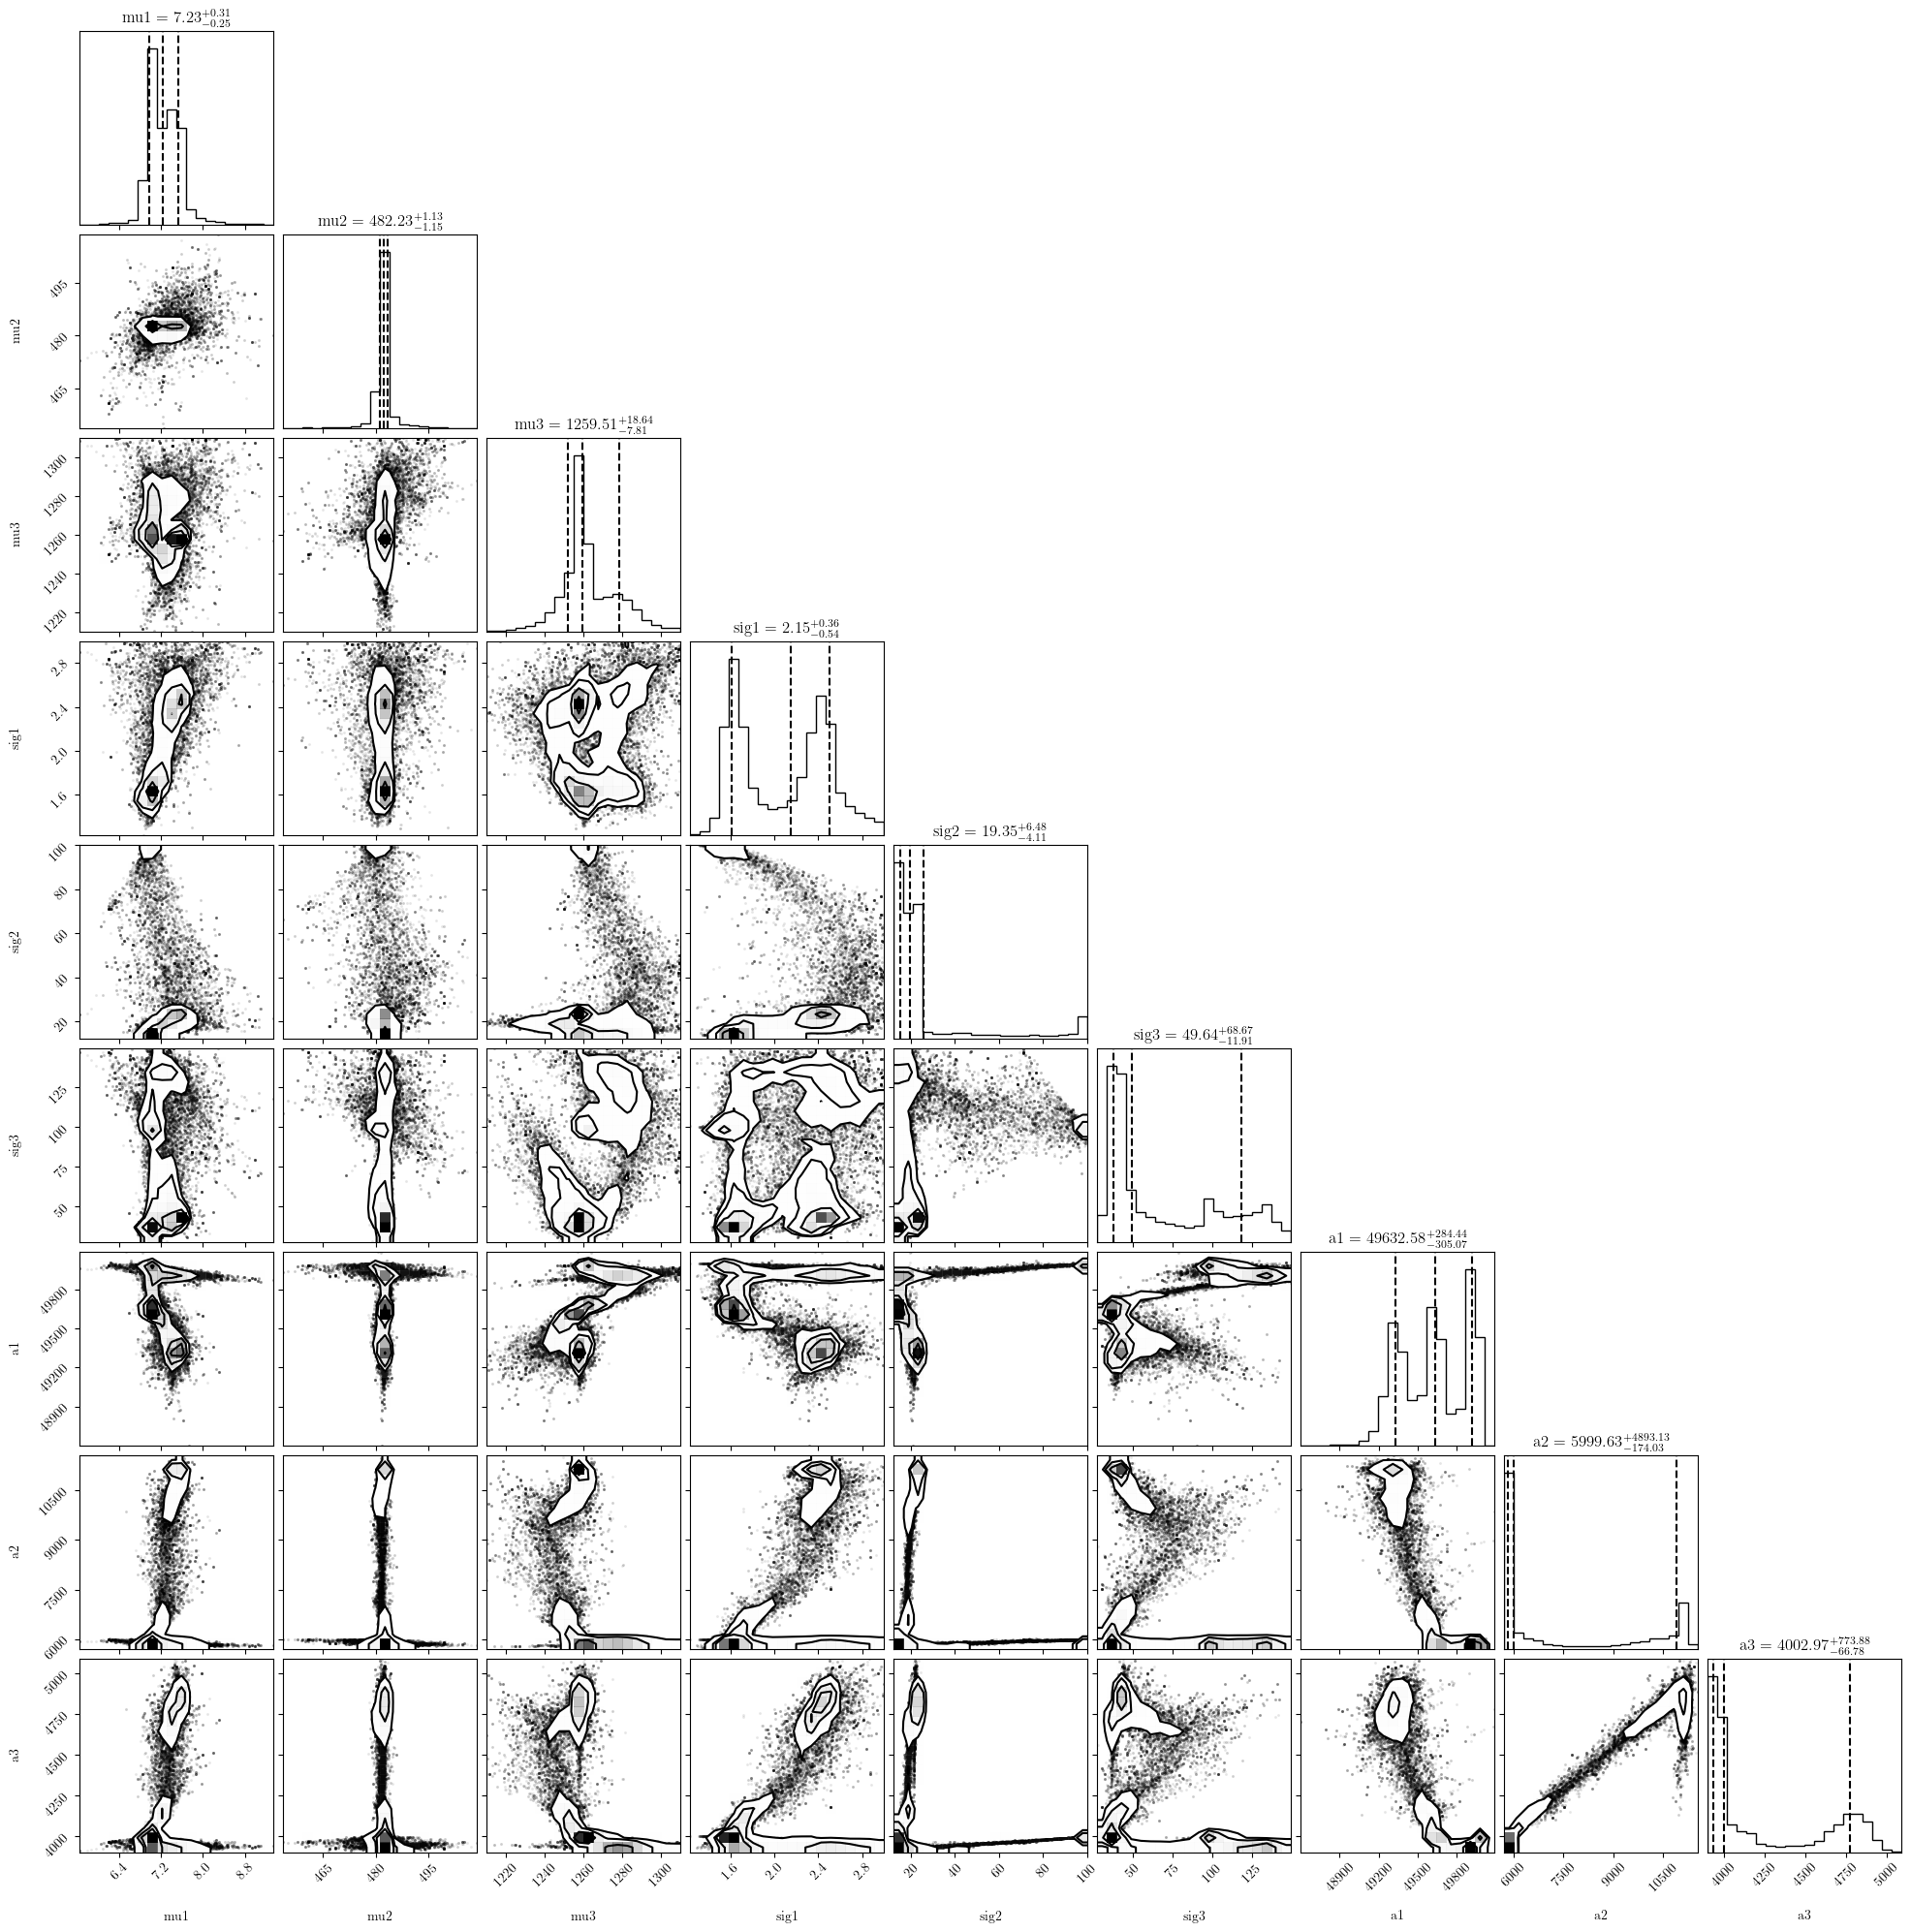

/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


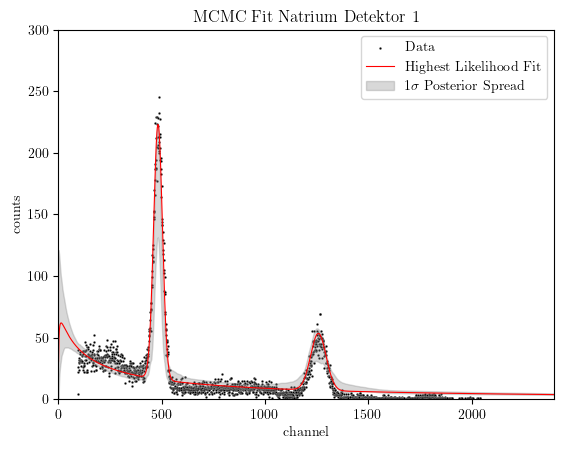

Hyperparameter: 
 [7.36757422e+00 4.82430441e+02 1.25824155e+03 2.18458172e+00
 2.12227435e+01 3.75687545e+01 4.93482533e+04 1.10032007e+04
 4.35210359e+03]


In [9]:
# reading data
df = pd.read_csv('Results/energiespektrum_natrium_detektor1.asc')
df.columns = ['counts']
df.index.name = 'channel'
df['counts'] = df.loc[df['counts'] > 0]

#------------------------------------------------------------------------------------------------------------
# model building

def model(theta,ch=df.index):
    # mu0, mu1,mu2,mu3,sig0,sig1,sig2,sig3,a0,a1,a2,a3 = theta
    mu0,mu2,mu3,sig0,sig2,sig3,a0,a2,a3 = theta
    lognormal0 = np.divide(1,ch*sig0*np.sqrt(2*np.pi)) * np.exp(-np.divide(np.power(np.log(ch)-mu0,2),2*sig0**2))
    # gaussian1 = np.divide(1,sig1*np.sqrt(2*np.pi)) * np.exp(-(ch-mu1)**2 / (2*sig1**2) )
    gaussian2 = np.divide(1,sig2*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu2) /sig2 )**2 / 2)
    gaussian3 = np.divide(1,sig3*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu3) /sig3 )**2 / 2)
    return a0*lognormal0 + a2*gaussian2 + a3*gaussian3 

def lnlike(theta, ch, value, value_err):
    return -0.5 * np.sum(((value - model(theta, ch))/value_err) ** 2)

def lnprior(theta):
    # mu0,mu1,mu2,mu3,sig0,sig1,sig2,sig3,a0,a1,a2,a3 = theta
    mu0,mu2,mu3,sig0,sig2,sig3,a0,a2,a3 = theta
    # if  0.0 < mu0 < 10.0 and 700.0 < mu1 < 1000.0 and 430.0 < mu2 < 530.0 and 1210.0 < mu3 < 1310.0 and 0.0 < sig0 < 3.0 and 400.0 < sig1 < 1000.0 and 0.0 < sig2 < 150.0 and 0.0 < sig3 < 150.0 and 1e4 < a0 < 1e5 and 1e4 < a1 < 3e4 and 0.0 < a2 < 250.0 and 0.0 < a3 < 80:
    #     return 0.0
    if  0.0 < mu0 < 10.0 and 430.0 < mu2 < 530.0 and 1210.0 < mu3 < 1310.0 and 0.0 < sig0 < 3.0 and 0.0 < sig2 < 150.0 and 0.0 < sig3 < 150.0 and 1e4 < a0 < 1e5 and 0.0 < a2 < 1.5e4 and 0.0 < a3 < 8e3:
        return 0.0
    return -np.inf

def lnprob(theta, ch, value, value_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, ch, value, value_err)

count_err = 0.05*df['counts'].mean() # arbitrary error bar; we may need to look at the precision of the TSCA
data = (df.index, df['counts'], count_err)
initial = np.array([7.0, 480.0, 1260.0, 1.0, 100.0, 100.0, 50000.0, 6000.0, 4000.0])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    start = time.time()
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    print("Starting burn-in period")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    print("Burn-in period complete")
    print("Starting chains") # this will take 1-5 minutes depending on the size of the walkers and iterations, about 60s for 128 walkers and 500 chains
    pos, prob, state = sampler.run_mcmc(p0, niter)
    print("...Complete!")
    
    end = time.time()
    print("Time required:  ",end - start)
    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

def mcmcplot(sampler,ch=df.index,val=df['counts']):
    plt.ion()
    sns.scatterplot(x=ch,y=val, s=3, color='k', label='Data')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(ch, model(theta, ch), color="r", alpha=0.1, linewidth=.5)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('channel')
    plt.ylabel('counts')
    ax = plt.gca()
    ax.set_xlim([0,2400])
    ax.set_ylim([0,300])
    plt.title("MCMC Ketten (rot) Natrium Detektor 1")
    plt.legend()
    plt.savefig("plots/MCMC Natrium Detektor 1 Chains.pdf")
    plt.show()

mcmcplot(sampler)

samples = sampler.flatchain
hyperparameter_na1 = samples[np.argmax(sampler.flatlnprobability)] # fitted hyperparameter with best values
mcmcfit = model(hyperparameter_na1)

#------------------------------------------------------------------------------------------------------------
# diagnosis corner plot

labels = ['mu1','mu2','mu3','sig1','sig2','sig3','a1','a2','a3']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
plt.savefig("plots/MCMC Natrium Detektor 1 Hyperparameters.pdf")
plt.show()
#------------------------------------------------------------------------------------------------------------
# result plot

def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,samples)

sns.scatterplot(x=df.index,y=df['counts'], s=3, color='k', label='Data')
plt.plot(df.index,mcmcfit, color='r',linewidth=.8, label='Highest Likelihood Fit')
plt.fill_between(df.index,med_model-spread,med_model+spread,color='grey',alpha=0.3,label=r'$1\sigma$ Posterior Spread')
plt.xlabel('channel')
plt.ylabel('counts')
ax = plt.gca()
ax.set_xlim([0,2400])
ax.set_ylim([0,300])
plt.title("MCMC Fit Natrium Detektor 1")
plt.legend()
plt.savefig("plots/MCMC Natrium Detektor 1 Fit.pdf")
plt.show()
print('Hyperparameter: \n',hyperparameter_na1)

## Sodium at detector 2
Similar model as before: one lognormal distribution and two gaussian distributions. Here, we include one more parameter, $b_1$, to look for optimal peak for the lognormal distribution:
$$
    P_{logn}((a,b,\mu,\sigma), x) = a \cdot \frac{1}{(x-b) \cdot \sigma \sqrt{2\pi}} \exp \left[ -\frac{1}{2} \left ( \frac{\ln (x-b) - \mu}{\sigma} \right )^2  \right]
$$

Starting burn-in period


/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


Burn-in period complete
Starting chains
...Complete!
Time required:   173.56260991096497


/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


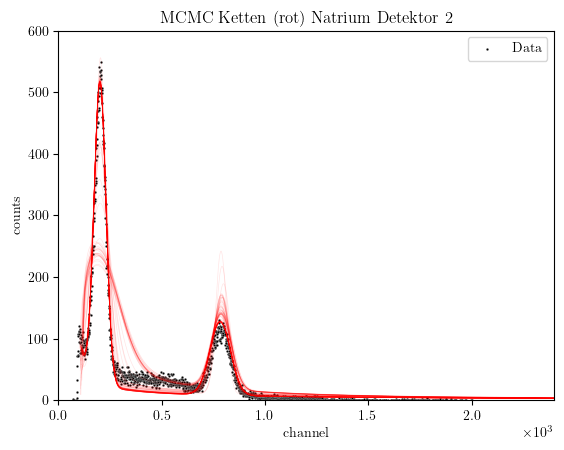

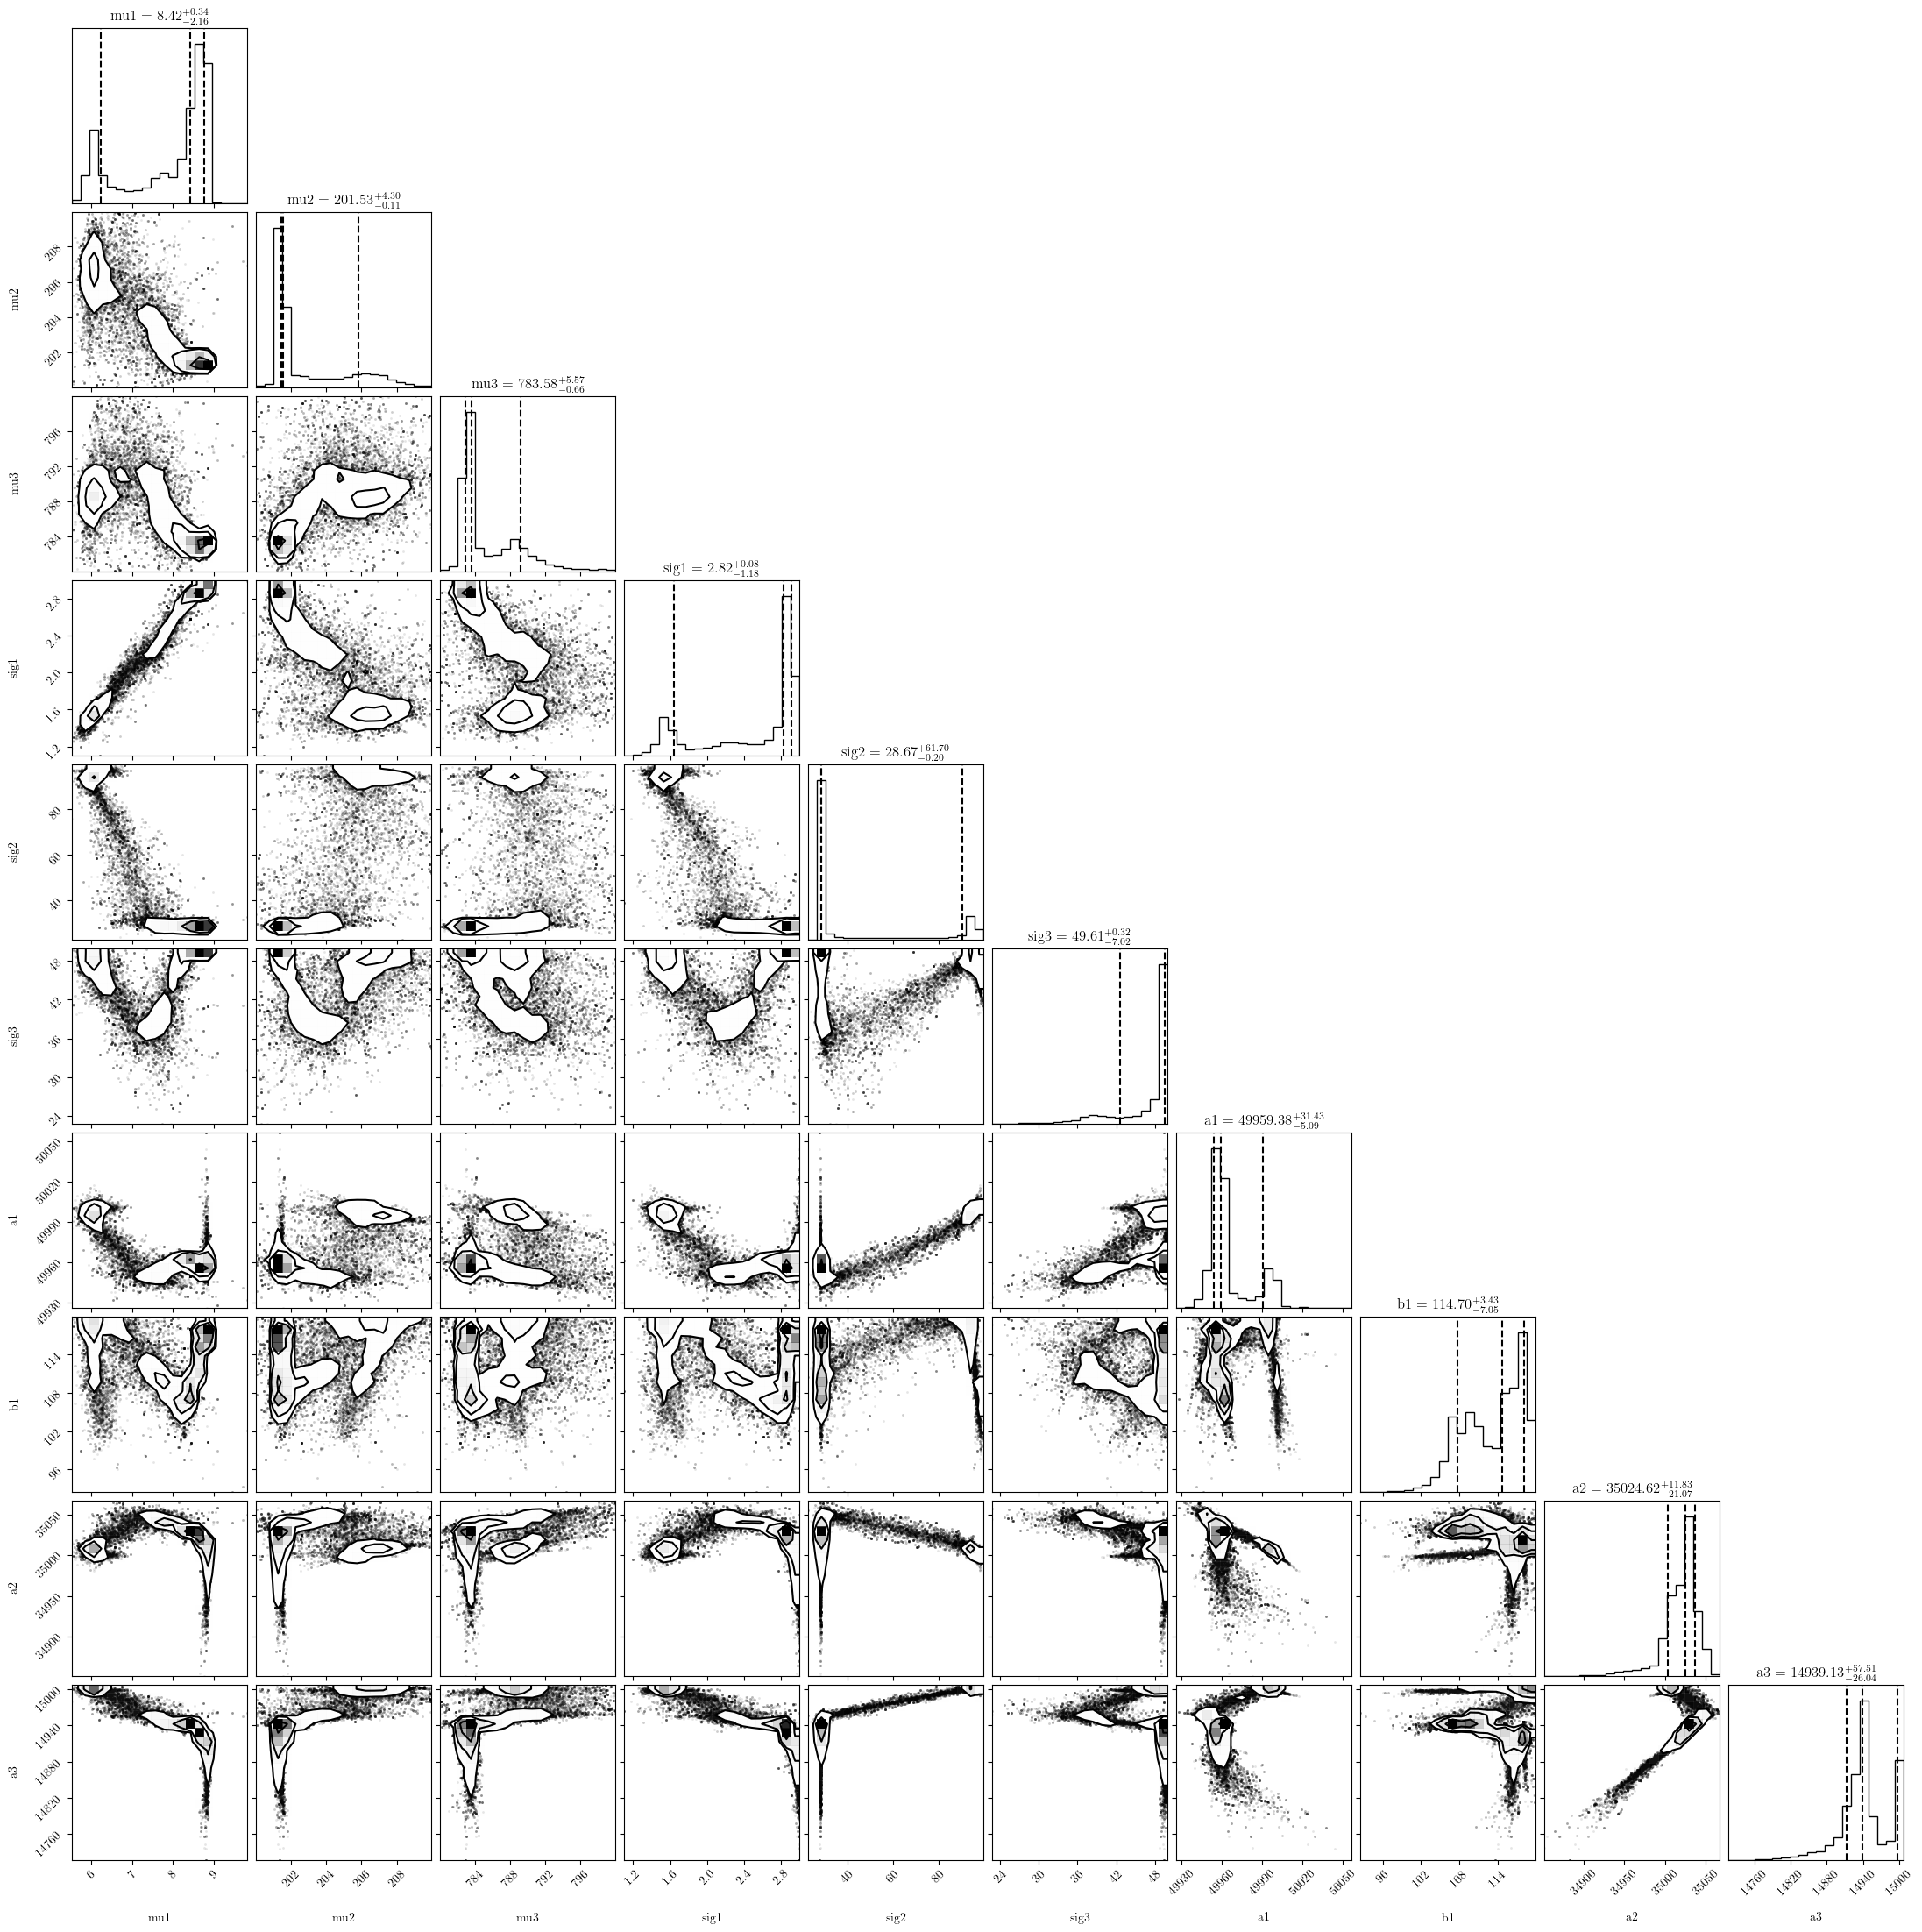

/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


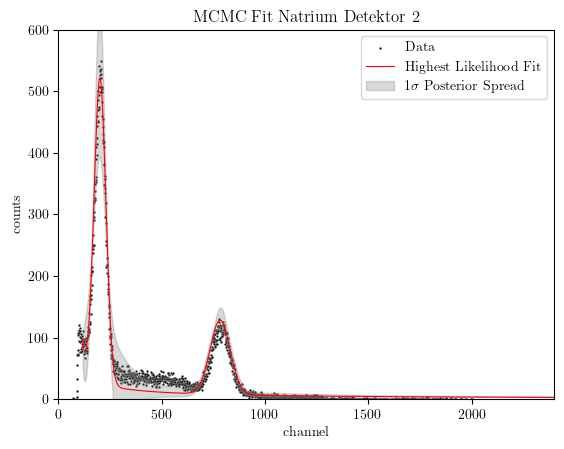

Hyperparameter: 
 [8.75052982e+00 2.01531060e+02 7.82917911e+02 2.98672741e+00
 2.81545371e+01 4.87398186e+01 4.99825450e+04 1.16058033e+02
 3.48522282e+04 1.47374849e+04]


In [10]:
# reading data
df = pd.read_csv('Results/energiespektrum_natrium_detektor2.asc')
df.columns = ['counts']
df.index.name = 'channel'
df['counts'] = df.loc[df['counts'] > 0]

#------------------------------------------------------------------------------------------------------------
# model building

def model(theta,ch=df.index):
    mu1,mu2,mu3,sig1,sig2,sig3,a1,b1,a2,a3 = theta
    lognormal1 = np.divide(1,(ch-b1)*sig1*np.sqrt(2*np.pi)) * np.exp(-np.divide(np.power(np.log(ch-b1)-mu1,2),2*sig1**2))
    gaussian2 = np.divide(1,sig2*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu2) /sig2 )**2 / 2)
    gaussian3 = np.divide(1,sig3*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu3) /sig3 )**2 / 2)
    return a1*lognormal1 + a2*gaussian2 + a3*gaussian3 

def lnlike(theta, ch, value, value_err):
    return -0.5 * np.sum(((value - model(theta, ch))/value_err) ** 2)

def lnprior(theta):
    mu1,mu2,mu3,sig1,sig2,sig3,a1,b1,a2,a3 = theta
    if 0.0 < mu1 < 10.0 and 200.0 < mu2 < 210.0 and 780.0 < mu3 < 800.0 and 0.0 < sig1 < 3.0 and 0.0 < sig2 < 150.0 and 0.0 < sig3 < 50.0 and 1e4 < a1 < 7e4 and 0.0 < b1 < 120.0 and 0.0 < a2 < 5e4 and 0.0 < a3 < 4e4:
        return 0.0
    return -np.inf

def lnprob(theta, ch, value, value_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, ch, value, value_err)

count_err = 0.05*df['counts'].mean() # arbitrary error bar; we may need to look at the precision of the TSCA
data = (df.index, df['counts'], count_err)
initial = np.array([7.0, 205.0, 790.0, 2.3, 100.0, 40.0, 50000.0, 100.0 , 3.5e4, 1.5e4])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    start = time.time()
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    print("Starting burn-in period")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    print("Burn-in period complete")
    print("Starting chains") # this will take 1-5 minutes depending on the size of the walkers and iterations
    pos, prob, state = sampler.run_mcmc(p0, niter)
    print("...Complete!")
    
    end = time.time()
    print("Time required:  ",end - start)
    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

def mcmcplot(sampler,ch=df.index,val=df['counts']):
    plt.ion()
    sns.scatterplot(x=ch,y=val, s=3, color='k', label='Data')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(ch, model(theta, ch), color="r", alpha=0.1, linewidth=.5)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('channel')
    plt.ylabel('counts')
    ax = plt.gca()
    ax.set_xlim([0,2400])
    ax.set_ylim([0,600])
    plt.title("MCMC Ketten (rot) Natrium Detektor 2")
    plt.legend()
    plt.savefig("plots/MCMC Natrium Detektor 2 Chains.pdf")
    plt.show()

mcmcplot(sampler)

samples = sampler.flatchain
hyperparameter_na2 = samples[np.argmax(sampler.flatlnprobability)] # fitted hyperparameter with best values
mcmcfit = model(hyperparameter_na2)

#------------------------------------------------------------------------------------------------------------
# diagnosis corner plot

labels = ['mu1','mu2','mu3','sig1','sig2','sig3','a1','b1','a2','a3']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
plt.savefig("plots/MCMC Natrium Detektor 2 Hyperparameters.pdf")
plt.show()

#------------------------------------------------------------------------------------------------------------
# result plot

def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,samples)

sns.scatterplot(x=df.index,y=df['counts'], s=3, color='k', label='Data')
plt.plot(df.index,mcmcfit, color='r',linewidth=.8, label='Highest Likelihood Fit')
plt.fill_between(df.index,med_model-spread,med_model+spread,color='grey',alpha=0.3,label=r'$1\sigma$ Posterior Spread')
plt.xlabel('channel')
plt.ylabel('counts')
ax = plt.gca()
ax.set_xlim([0,2400])
ax.set_ylim([0,600])
plt.title("MCMC Fit Natrium Detektor 2")
plt.legend()
plt.savefig("plots/MCMC Natrium Detektor 2 Fit.pdf")
plt.show()
print('Hyperparameter: \n',hyperparameter_na2)

## Cobalt at detector 1

Starting burn-in period


/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/alex/.local/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Burn-in period complete
Starting chains
...Complete!
Time required:   193.7471845149994


/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


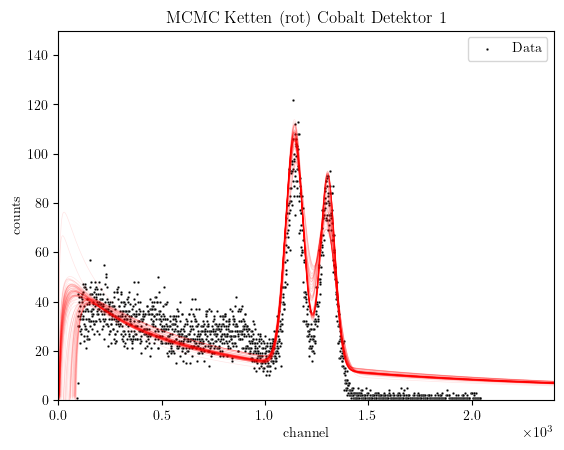

/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


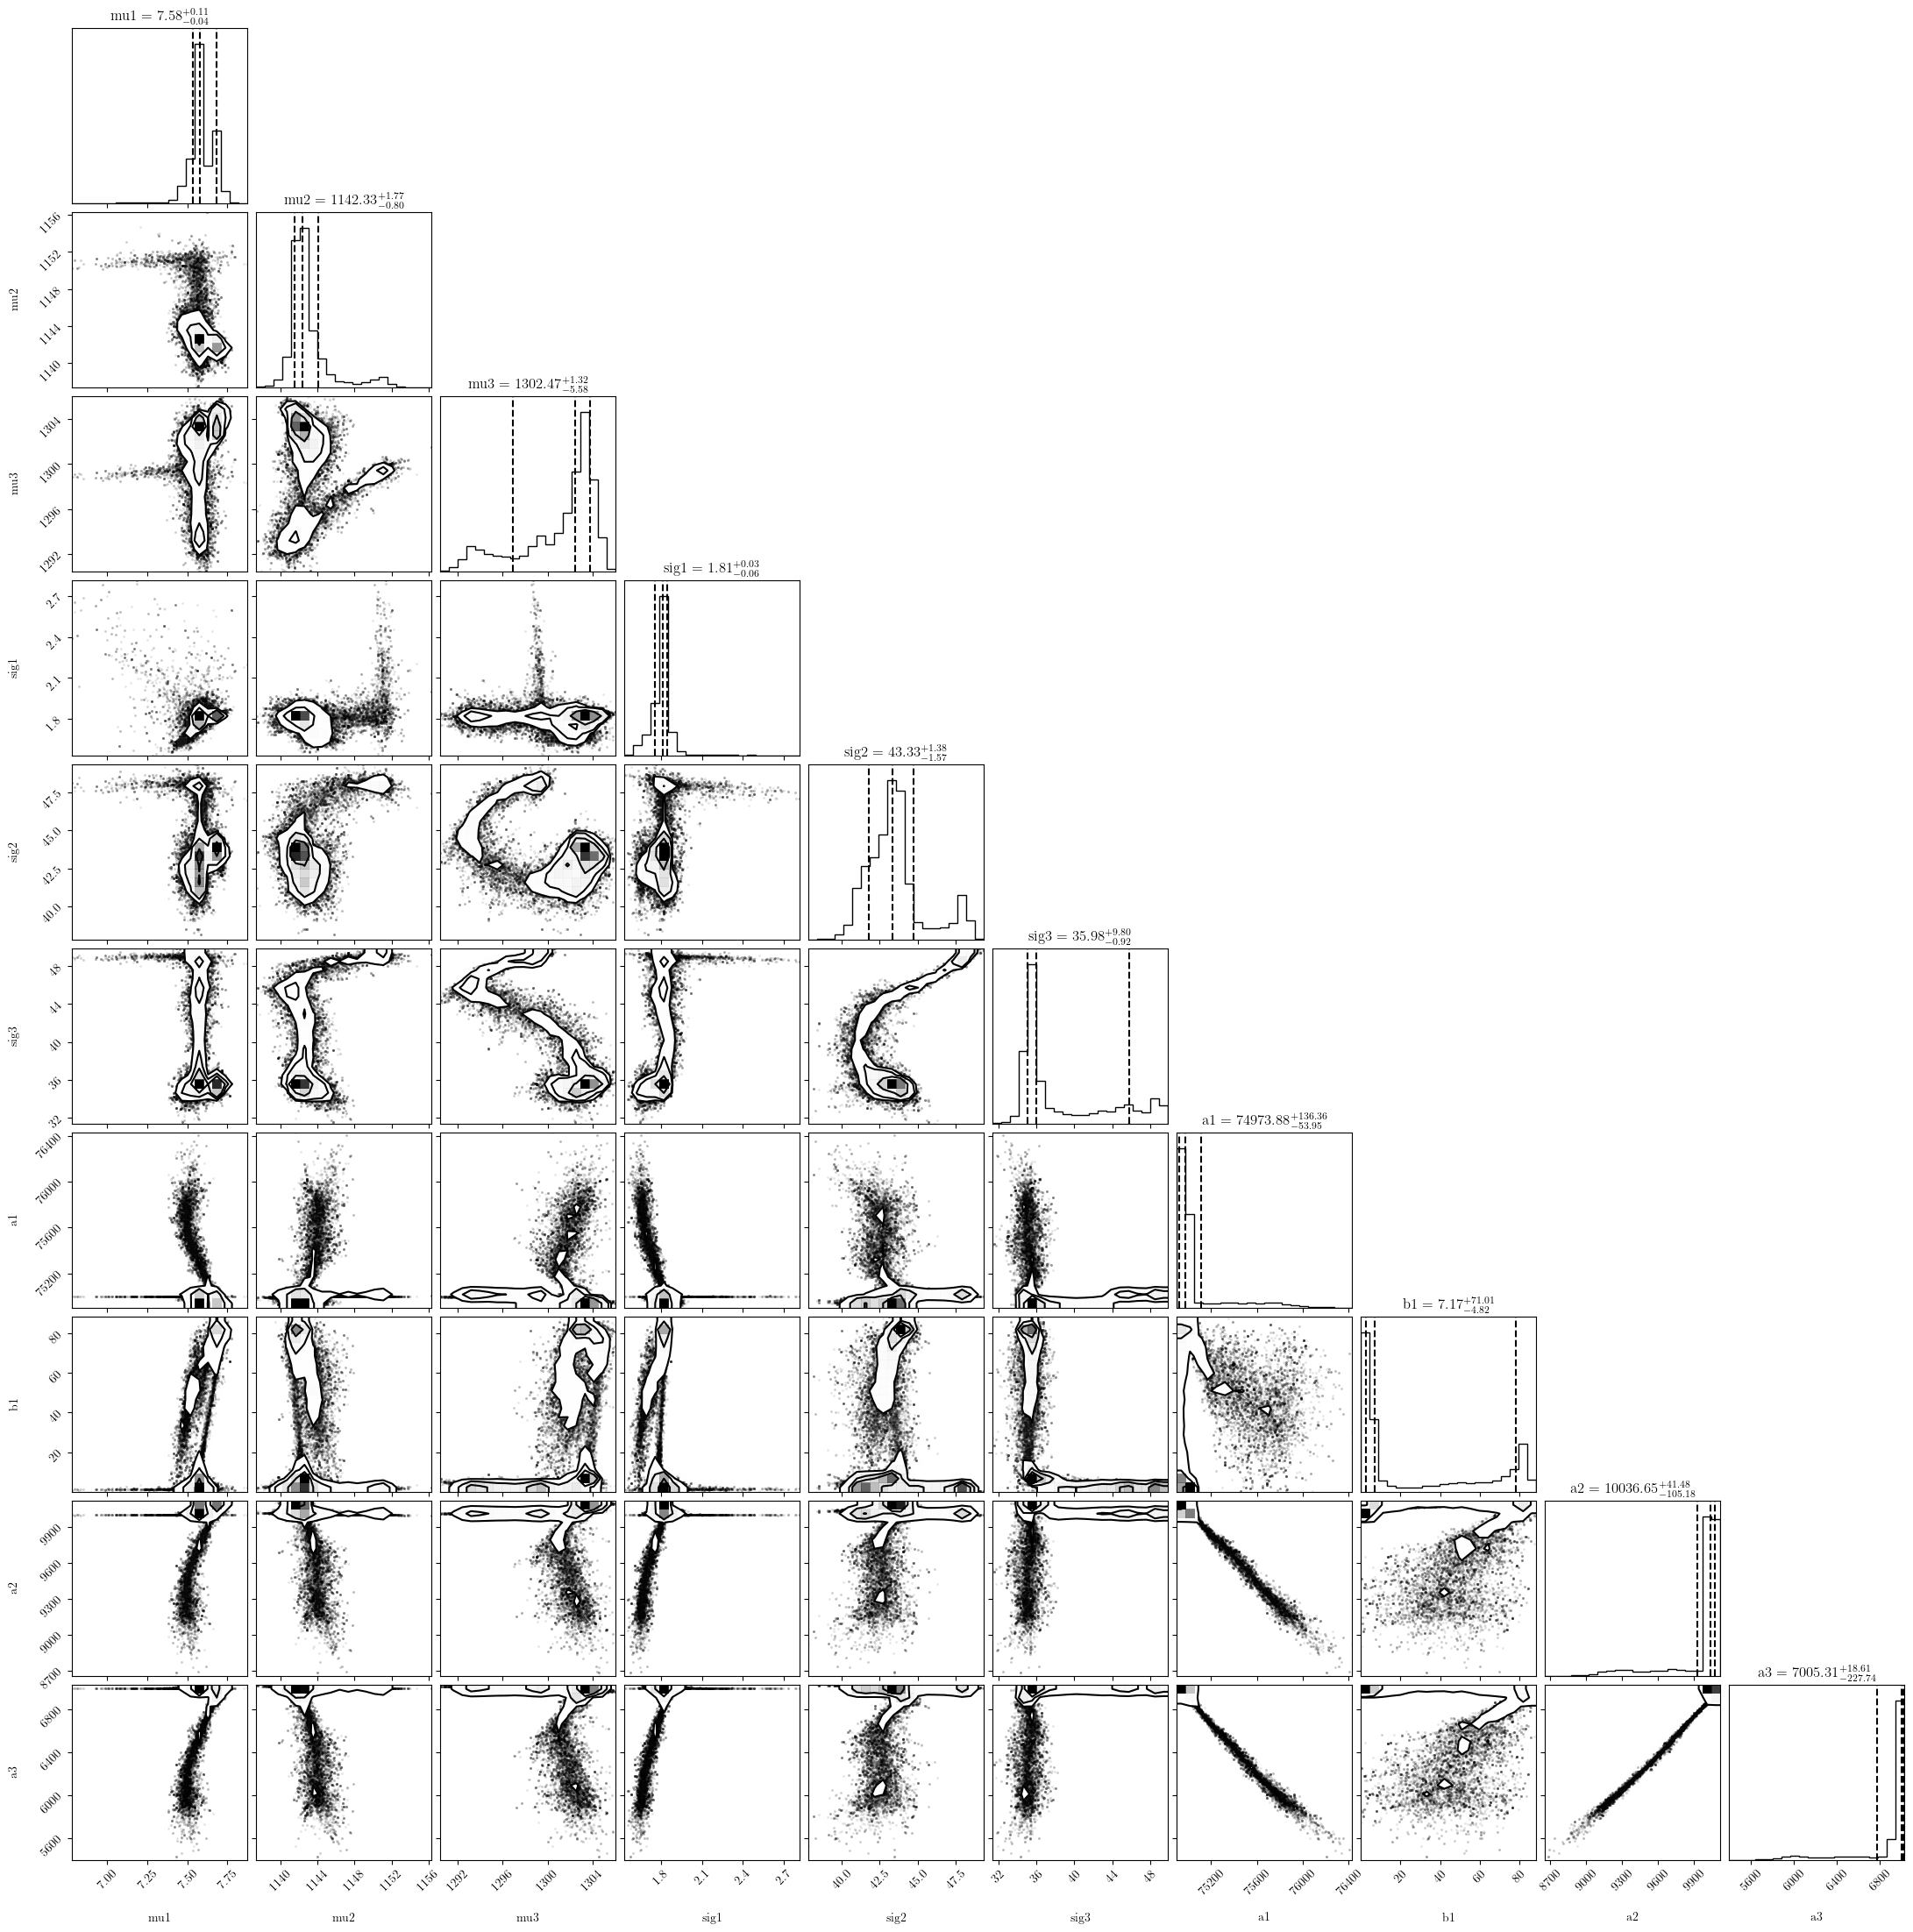

/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


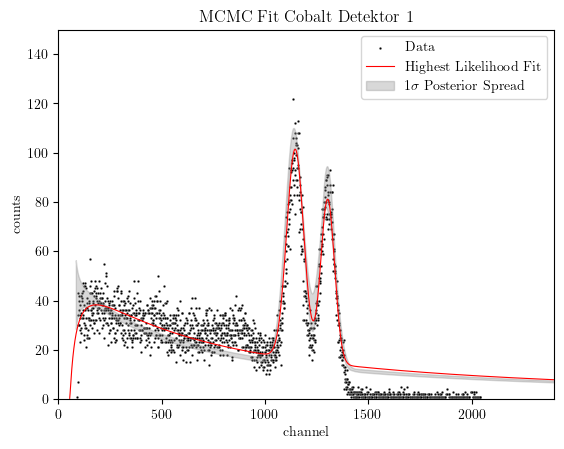

Hyperparameter: 
 [7.52054461e+00 1.14617421e+03 1.30313010e+03 1.63163158e+00
 4.12109571e+01 3.33321694e+01 7.63134808e+04 5.41652474e+01
 8.80008651e+03 5.56111784e+03]


In [11]:
# reading data
df = pd.read_csv('Results/energiespektrum_cobalt_detektor1.asc')
df.columns = ['counts']
df.index.name = 'channel'
df['counts'] = df.loc[df['counts'] > 0]

#------------------------------------------------------------------------------------------------------------
# model building

def model(theta,ch=df.index):
    mu1,mu2,mu3,sig1,sig2,sig3,a1,b1,a2,a3 = theta
    lognormal1 = np.divide(1,(ch-b1)*sig1*np.sqrt(2*np.pi)) * np.exp(-np.divide(np.power(np.log(ch-b1)-mu1,2),2*sig1**2))
    gaussian2 = np.divide(1,sig2*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu2) /sig2 )**2 / 2)
    gaussian3 = np.divide(1,sig3*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu3) /sig3 )**2 / 2)
    return a1*lognormal1 + a2*gaussian2 + a3*gaussian3 

def lnlike(theta, ch, value, value_err):
    return -0.5 * np.sum(((value - model(theta, ch))/value_err) ** 2)

def lnprior(theta):
    mu1,mu2,mu3,sig1,sig2,sig3,a1,b1,a2,a3 = theta
    if 0.0 < mu1 < 10.0 and 1100.0 < mu2 < 1200.0 and 1250.0 < mu3 < 1350.0 and 0.0 < sig1 < 3.0 and 0.0 < sig2 < 50.0 and 0.0 < sig3 < 50.0 and 5000 < a1 < 8e4 and 0 < b1 < 200 and 0.0 < a2 < 2e4 and 0.0 < a3 < 1e4:
        return 0.0
    return -np.inf

def lnprob(theta, ch, value, value_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, ch, value, value_err)

count_err = 0.05*df['counts'].mean() # arbitrary error bar; we may need to look at the precision of the TSCA
data = (df.index, df['counts'], count_err)
initial = np.array([6.5, 1150.0, 1300.0, 1.0, 50.0, 50.0, 75000.0, 0.0 , 1e4, 7000.0])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    start = time.time()
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    print("Starting burn-in period")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    print("Burn-in period complete")
    print("Starting chains") # this will take 1-5 minutes depending on the size of the walkers and iterations
    pos, prob, state = sampler.run_mcmc(p0, niter)
    print("...Complete!")
    
    end = time.time()
    print("Time required:  ",end - start)
    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

def mcmcplot(sampler,ch=df.index,val=df['counts']):
    plt.ion()
    sns.scatterplot(x=ch,y=val, s=3, color='k', label='Data')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(ch, model(theta, ch), color="r", alpha=0.1, linewidth=.5)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('channel')
    plt.ylabel('counts')
    ax = plt.gca()
    ax.set_xlim([0,2400])
    ax.set_ylim([0,150])
    plt.title("MCMC Ketten (rot) Cobalt Detektor 1")
    plt.legend()
    plt.savefig("plots/MCMC Cobalt Detektor 1 Chains.pdf")
    plt.show()

mcmcplot(sampler)

samples = sampler.flatchain
hyperparameter_co1 = samples[np.argmax(sampler.flatlnprobability)] # fitted hyperparameter with best values
mcmcfit = model(hyperparameter_co1)

#------------------------------------------------------------------------------------------------------------
# diagnosis corner plot

labels = ['mu1','mu2','mu3','sig1','sig2','sig3','a1','b1','a2','a3']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
plt.savefig("plots/MCMC Cobalt Detektor 1 Hyperparameters.pdf")
plt.show()

#------------------------------------------------------------------------------------------------------------
# result plot

def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,samples)

sns.scatterplot(x=df.index,y=df['counts'], s=3, color='k', label='Data')
plt.plot(df.index,mcmcfit, color='r',linewidth=.8, label='Highest Likelihood Fit')
plt.fill_between(df.index,med_model-spread,med_model+spread,color='grey',alpha=0.3,label=r'$1\sigma$ Posterior Spread')
plt.xlabel('channel')
plt.ylabel('counts')
ax = plt.gca()
ax.set_xlim([0,2400])
ax.set_ylim([0,150])
plt.title("MCMC Fit Cobalt Detektor 1")
plt.legend()
plt.savefig("plots/MCMC Cobalt Detektor 1 Fit.pdf")
plt.show()
print('Hyperparameter: \n',hyperparameter_co1)

## Cobalt at detector 2
This time, the lower-value spectrum has a short tail. In this case, we better fit it with a gamma distribution or a custom exponential function. \
We choose two additional custom exponential functions, as there four peaks to be seen: two at the cascade peaks and two at lower values. 

Starting burn-in period
Burn-in period complete
Starting chains
...Complete!
Time required:   172.3443787097931


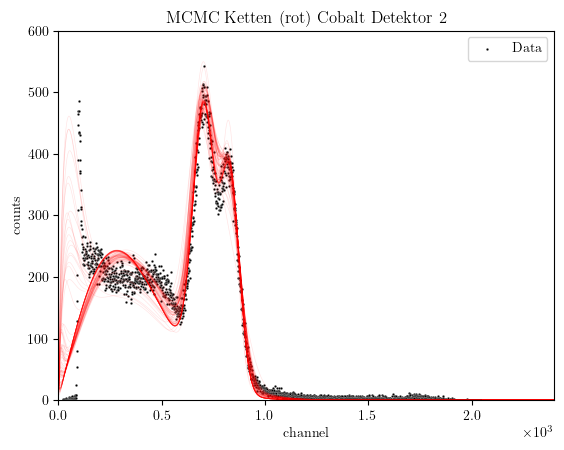

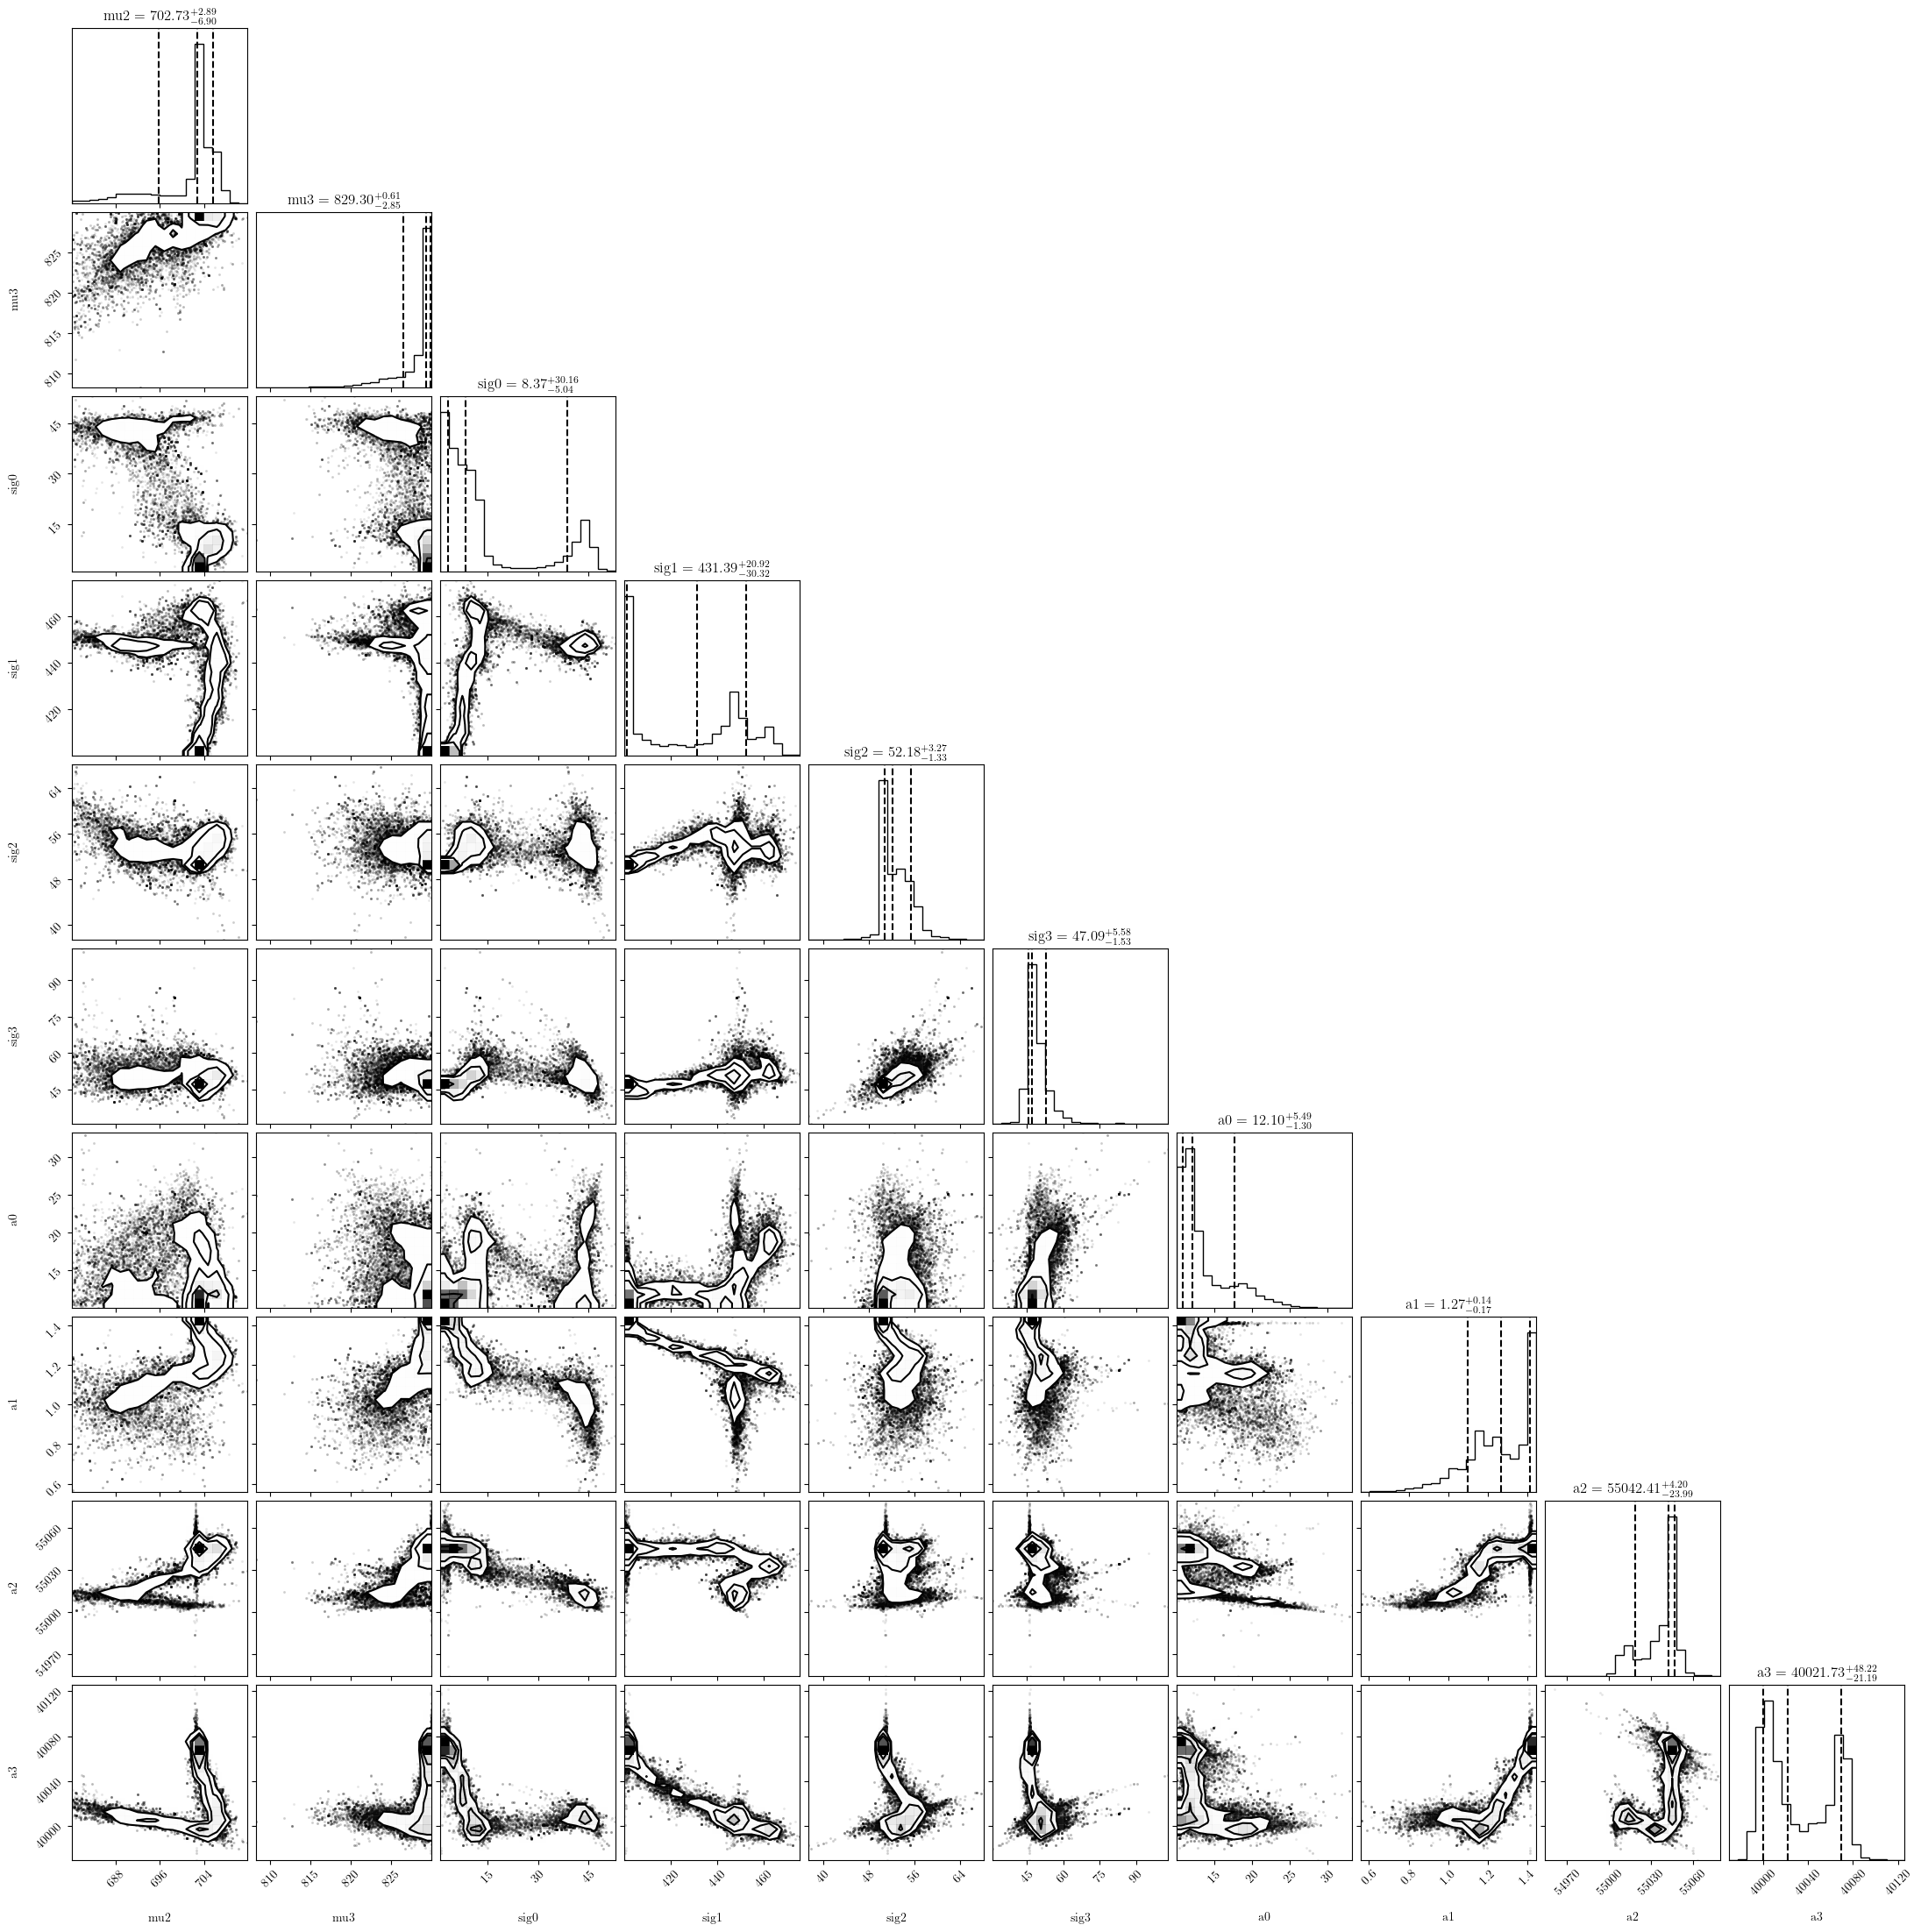

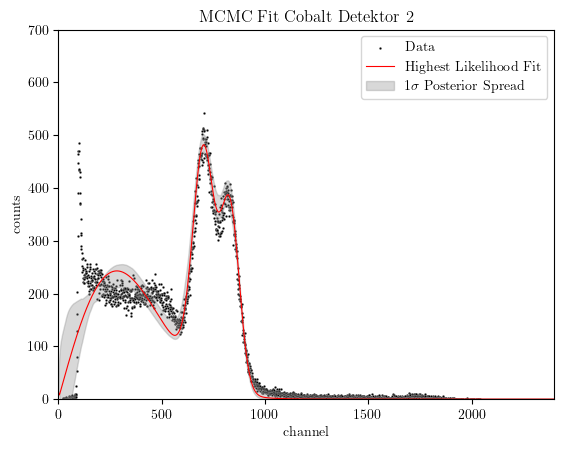

Hyperparameter: 
 [7.02637363e+02 8.29863562e+02 1.01944979e+00 4.00427897e+02
 5.12717524e+01 4.60472029e+01 2.87289866e+01 1.41399969e+00
 5.50628907e+04 3.99701862e+04]


In [12]:
# reading data
df = pd.read_csv('Results/energiespektrum_cobalt_detektor2.asc')
df.columns = ['counts']
df.index.name = 'channel'
df['counts'] = df.loc[df['counts'] > 0]

#------------------------------------------------------------------------------------------------------------
# model building

def model(theta,ch=df.index):
    mu2,mu3,sig0,sig1,sig2,sig3,a0,a1,a2,a3 = theta
    # lognormal1 = np.divide(1,(ch-b1)*sig1*np.sqrt(2*np.pi)) * np.exp(-np.divide(np.power(np.log(ch-b1)-mu1,2),2*sig1**2))
    exp0 = ch*np.exp(-ch/sig0)
    exp1 = ch*np.exp(-(ch/sig1)**2)
    gaussian2 = np.divide(1,sig2*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu2) /sig2 )**2 / 2)
    gaussian3 = np.divide(1,sig3*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu3) /sig3 )**2 / 2)
    return a0*exp0 + a1*exp1 + a2*gaussian2 + a3*gaussian3 

def lnlike(theta, ch, value, value_err):
    return -0.5 * np.sum(((value - model(theta, ch))/value_err) ** 2)

def lnprior(theta):
    mu2,mu3,sig0,sig1,sig2,sig3,a0,a1,a2,a3 = theta
    if 680.0 < mu2 < 720.0 and 790.0 < mu3 < 830.0 and 1.0 < sig0 < 100.0 and 400.0 < sig1 < 1000.0 and 0.0 < sig2 < 150.0 and 0.0 < sig3 < 150.0 and 10.0 < a0 < 50.0 and 0.5 < a1 < 10.0 and 0.0 < a2 < 7e4 and 0.0 < a3 < 6e4:
        return 0.0
    return -np.inf

def lnprob(theta, ch, value, value_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, ch, value, value_err)

count_err = 0.05*df['counts'].mean() # arbitrary error bar; we may need to look at the precision of the TSCA
data = (df.index, df['counts'], count_err)
initial = np.array([700.0, 815.0, 50.0 , 450.0, 50.0, 50.0, 30.0, 1.0, 5.5e4, 4e4])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    start = time.time()
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    print("Starting burn-in period")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    print("Burn-in period complete")
    print("Starting chains") # this will take 1-5 minutes depending on the size of the walkers and iterations
    pos, prob, state = sampler.run_mcmc(p0, niter)
    print("...Complete!")
    
    end = time.time()
    print("Time required:  ",end - start)
    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

def mcmcplot(sampler,ch=df.index,val=df['counts']):
    plt.ion()
    sns.scatterplot(x=ch,y=val, s=3, color='k', label='Data')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(ch, model(theta, ch), color="r", alpha=0.1, linewidth=.5)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('channel')
    plt.ylabel('counts')
    ax = plt.gca()
    ax.set_xlim([0,2400])
    ax.set_ylim([0,600])
    plt.title("MCMC Ketten (rot) Cobalt Detektor 2")
    plt.legend()
    plt.savefig("plots/MCMC Cobalt Detektor 2 Chains.pdf")
    plt.show()

mcmcplot(sampler)

samples = sampler.flatchain
hyperparameter_co2 = samples[np.argmax(sampler.flatlnprobability)] # fitted hyperparameter with best values
mcmcfit = model(hyperparameter_co2)

#------------------------------------------------------------------------------------------------------------
# diagnosis corner plot

labels = ['mu2','mu3','sig0','sig1','sig2','sig3','a0','a1','a2','a3']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
plt.savefig("plots/MCMC Cobalt Detektor 2 Hyperparameters.pdf")
plt.show()

#------------------------------------------------------------------------------------------------------------
# result plot

def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,samples)

sns.scatterplot(x=df.index,y=df['counts'], s=3, color='k', label='Data')
plt.plot(df.index,mcmcfit, color='r',linewidth=.8, label='Highest Likelihood Fit')
plt.fill_between(df.index,med_model-spread,med_model+spread,color='grey',alpha=0.3,label=r'$1\sigma$ Posterior Spread')
plt.xlabel('channel')
plt.ylabel('counts')
ax = plt.gca()
ax.set_xlim([0,2400])
ax.set_ylim([0,700])
plt.title("MCMC Fit Cobalt Detektor 2")
plt.legend()
plt.savefig("plots/MCMC Cobalt Detektor 2 Fit.pdf")
plt.show()
print('Hyperparameter: \n',hyperparameter_co2)

## Linear regression of the peaks $\&$ energy calibration

Detector|sodium 511keV|sodium 1275keV|cobalt 1173.2keV|cobalt 1332.5keV|
:-|-|-|-|-|
D1|480|1260|1150|1300|
D2|205|790|700|810|

We capitalize on the fact that the channel value of the TSCA is linear proportional to the energy values to an accuracy of 1keV ["Grundlagen_gamma_FP16" page 46]:
$$
    E_\gamma = a + b \cdot K .
$$
This means that the difference in energies should be the same as the difference in channel values to a factor $b$ 
\begin{align}
    \Delta E_{\gamma} &= b \Delta K \\
    b &= \frac{\Delta E_{\gamma}}{\Delta K}
\end{align}
For the difference, we use the two peaks of the spectra. In theory, a third peak should arise from compton scattering, which could increase the precision of our calibration. But those peaks were hard to observe. In case of detector 2, we don't know for sure whether the peak at lower channel values is physical or not just some artifact. \
We can determine $a$ by inserting any matching pair of channel value and energy peak, i.e. 480 and 511 for sodium at detector 1.

In [13]:
# peaks of spectra, initial guesses, helpful for later fitting
multiindex = [
    ["E", "E", "D1", "D1", "D2", "D2"],
    ["p1", "p2","p1", "p2", "p1", "p2"],
]
tuples = list(zip(*multiindex))
index = pd.MultiIndex.from_tuples(tuples, names=["Theoretical / Detector","Peak"])
source = pd.DataFrame({"na":[511,1275,hyperparameter_na1[1],hyperparameter_na1[2],hyperparameter_na2[1],hyperparameter_na2[2]],
                       "co":[1173.2,1332.5,hyperparameter_co1[1],hyperparameter_co1[2],hyperparameter_co2[0],hyperparameter_co2[1]]}, index=index)
ic(source)
def peak(d,p,s):
    '''
    d: E, D1 or D2
    p: p1 or p2
    s: na or co
    example use: ic(peak('D1','p1','na'))
    '''
    return float(source.loc[(d,p),s])

ic| source:                                       na           co
            Theoretical / Detector Peak                          
            E                      p1     511.000000  1173.200000
                                   p2    1275.000000  1332.500000
            D1                     p1     482.430441  1146.174209
                                   p2    1258.241546  1303.130097
            D2                     p1     201.531060   702.637363
                                   p2     782.917911   829.863562


ic| calibration:                                     na          co
                 Detector Calibration value                        
                 D1       a                   35.914179    9.907850
                          b                    0.984776    1.014935
                 D2       a                  246.168195  293.427334
                          b                    1.314099    1.252101
ic| calibrate('D1','na',480): 508.6065609867391


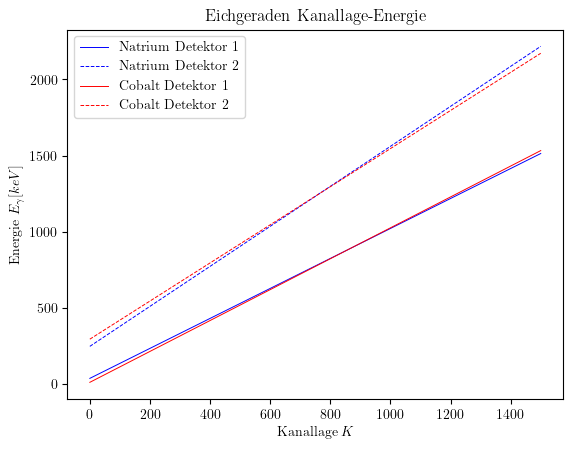

In [14]:
delta_E_na = peak('E','p2','na') - peak('E','p1','na') # Delta E

delta_D1_na = peak('D1','p2','na') - peak('D1','p1','na') # Delta K

b_D1_na = delta_E_na / delta_D1_na # determine b
a_D1_na = peak('E','p1','na') - b_D1_na * peak('D1','p1','na') # determine a

delta_D2_na = peak('D2','p2','na') - peak('D2','p1','na')
b_D2_na = delta_E_na / delta_D2_na 
a_D2_na = peak('E','p1','na') - b_D2_na * peak('D2','p1','na')


delta_E_co = peak('E','p2','co') - peak('E','p1','co')

delta_D1_co = peak('D1','p2','co') - peak('D1','p1','co') 
b_D1_co = delta_E_co / delta_D1_co
a_D1_co = peak('E','p1','co') - b_D1_co * peak('D1','p1','co')

delta_D2_co = peak('D2','p2','co') - peak('D2','p1','co')
b_D2_co = delta_E_co / delta_D2_co 
a_D2_co = peak('E','p1','co') - b_D2_co * peak('D2','p1','co')


multiindex2 = [
    ["D1", "D1", "D2", "D2"],
    ["a", "b", "a", "b"],
]
tuples = list(zip(*multiindex2))
index2 = pd.MultiIndex.from_tuples(tuples, names=["Detector","Calibration value"])
calibration = pd.DataFrame({"na":[a_D1_na,b_D1_na,a_D2_na,b_D2_na],
                       "co":[a_D1_co,b_D1_co,a_D2_co,b_D2_co]}, index=index2)

ic(calibration)

def calibrate(d,s,ch):
    '''
    d: detector, D1 or D2 
    s: source, na or co
    ch: channel value, float
    '''
    a = calibration.loc[(d,'a'),s]
    b = calibration.loc[(d,'b'),s]
    E = a + b*ch
    return E
ic(calibrate('D1','na',480)) # test

ch = np.linspace(0,1500,1000)
fig, ax = plt.subplots()
ax.plot(ch, calibrate('D1','na',ch), 'b', linewidth=.7, label='Natrium Detektor 1')
ax.plot(ch, calibrate('D2','na',ch), 'b--', linewidth=.7,label='Natrium Detektor 2')
ax.plot(ch, calibrate('D1','co',ch), 'r', linewidth=.7,label='Cobalt Detektor 1')
ax.plot(ch, calibrate('D2','co',ch), 'r--', linewidth=.7,label='Cobalt Detektor 2')
ax.set_title('Eichgeraden Kanallage-Energie')
ax.set(xlabel=f'Kanallage $K$', ylabel=f'Energie $E_\\gamma [keV]$ ')
ax.legend()
def plt.show()

In [ ]:
def calibratedenergy(detector, source, data, color, title, filename):
    '''
        detector (string): D1 or D2
        source (string): na or co
        data (string): csv file
        color: b, b--, r, r--
        title (string)
        filename (string)
    '''
    df = pd.read_csv(data)
    df.columns = ['counts']
    df.index.name = 'channel'
    df['counts'] = df.loc[df['counts'] > 0]
    energy = calibrate(detector,source, df.index)
    
    fig, ax = plt.subplots()
    ax.plot(energy, df['counts']), color, linewidth=.7)
    ax.set_title(title)
    ax.set(xlabel=f'Energy', ylabel=f'counts')
    plt.savefig(filename)
    plt.show()
    
ax.plot(ch, calibrate('D2','na',ch), 'b--', linewidth=.7,label='Natrium Detektor 2')
ax.plot(ch, calibrate('D1','co',ch), 'r', linewidth=.7,label='Cobalt Detektor 1')
ax.plot(ch, calibrate('D2','co',ch), 'r--', linewidth=.7,label='Cobalt Detektor 2')
ax.set_title('Eichgeraden Kanallage-Energie')
ax.set(xlabel=f'Kanallage $K$', ylabel=f'Energie $E_\\gamma [keV]$ ')
ax.legend()
plt.show()